# Detecting changes in water and moisture indices

<b>Table of Contents</b>

- Overview
    - References
- Setup
    - Get Authentication Token
- Make Query
    - Utility funtions to display the tiff files
- Understanding the sample
    - Code
    - Output
        - Output Analysis
- NDMI and mNDWI applications

## Overview

Geospatial APIs allows to execute arbitrary math operations on data layers through *user defined functions* (UDFs). In this notebook we will use this feature to calculate moisture and water indices and observe the extent of change in the indices from Sentinel 2 data for a farmland in France.

The general idea behind these indices is that water reflects less radiation in the infrared range than other land cover. While it is hard to extract moisture content -- or even just the presence of water bodies -- from raw satellite data (whether in the visible part of the optical spectrum or not), these indices allow to obtain such information much more clearly.

Modified Normalized Difference Water Index (mNDWI) is a variant of the NDWI index used to detect water bodies in satellite or aerial images. This index is more effective compared to the NDWI index as it reduces characteristics of built-up areas that often correlate with open water in other indices.The formula for calculating it would be:

$mNDWI = \frac{(Green – SWIR)} {(Green + SWIR)}$

Normalized Difference Moisture Index (NDMI) is used to determine vegetation water content and asses drought conditions. The formula for calculating it would be:

$NDMI = \frac{(NIR - SWIR)} {(NIR + SWIR)}$

where Green = pixel values from the green band and SWIR = pixel values from the short-wave infrared band and NIR = near-infrared band 

### References

- https://en.wikipedia.org/wiki/Normalized_difference_water_index
- McFeeters, S.K. The use of the Normalized Difference Water Index (NDWI) in the delineation of open water
features. Int. J. Remote Sens. 1996, 17, 1425–1432.
- Xu, H. Modification of normalised difference water index (NDWI) to enhance open water features in remotely
sensed imagery. Int. J. Remote Sens. 2006.
- Feyisa, G.L.; Meilby, H.; Fensholt, R.; Proud, S.R. Automated Water Extraction Index: A new technique for
surface water mapping using Landsat imagery. Remote Sens. Environ. 2014, 140, 23–35. 


## Setup
Before starting, you have to install IBM EI Geospatial python SDK using `pip3 install -U ibmpairs`

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install rasterio
%pip install folium
%pip install configparser
%pip install matplotlib

In [2]:
#All imports needed for the sample
%matplotlib inline
import os, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from ibmpairs import client                      # represents an authenticated HTTP client
from ibmpairs import query                       # manages the submission of queries and retrieval of results
import ibmpairs.client as client
import ibmpairs.query as query
import json
import PIL
import configparser

Now, let's create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

### Get Authentication Token

In [ ]:
config = configparser.RawConfigParser()
config.read('../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                  tenant_id = EI_TENANT_ID,
                                  org_id    = EI_ORG_ID,
                                  legacy    = False ,
                                  version   = 3
                                 )

2024-10-30 10:40:49 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-10-30 10:40:49 - paw - INFO - Legacy Environment is False
2024-10-30 10:40:49 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-10-30 10:40:51 - paw - INFO - Authentication success.
2024-10-30 10:40:51 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Make Query

Let's make a raster query as below to calculate the water and moisture indices using Geospatial APIs layers 49686,49361 and 49681, which correspond to SWIR, NIR and Green bands of the High resolution imagery (ESA Sentinel 2) dataset, for a location in south-east of France for the months of March and June of 2023. The region queried for, covers a farmland next to a lake which undergoes a significant change in vegetation and water content through the season of Spring, which we aim to observe through this use case.

The layer IDs used here can be found using the catalog sub-module (refer [here](../../../tutorials/v3/catalog/general.ipynb) for details).We've used the formulae discussed above in the UDF expression as seen in the query.Refer to the [tutorials](https://pairs.res.ibm.com/tutorial/legacy/api/v01x/udfs.html) for details on UDFs.

Let's go ahead, define and submit the raster query and analyze the result.

In [4]:
# NDMI and mNDWI detection for 2023-03 and 2023-06
NDWI_query = query.submit_check_status_and_download(
  {'layers': [
  # raw Sentinel 2 Layers  
  {'alias': 'SWIR_1_202303', 'type': 'raster', 'id': '49686', 'temporal': {'intervals': [{'snapshot': '2023-03-05T00:00:00Z'}]}, 'output': False},
  {'alias': 'SWIR_1_202306', 'type': 'raster', 'id': '49686', 'temporal': {'intervals': [{'snapshot': '2023-06-23T00:00:00Z'}]}, 'output': False},
  {'alias': 'NIR_202303',    'type': 'raster', 'id': '49361', 'temporal': {'intervals': [{'snapshot': '2023-03-05T00:00:00Z'}]}, 'output': False},
  {'alias': 'NIR_202306',    'type': 'raster', 'id': '49361', 'temporal': {'intervals': [{'snapshot': '2023-06-23T00:00:00Z'}]}, 'output': False},
  {'alias': 'Green_202303',  'type': 'raster', 'id': '49681', 'temporal': {'intervals': [{'snapshot': '2023-03-05T00:00:00Z'}]}, 'output': False},
  {'alias': 'Green_202306',  'type': 'raster', 'id': '49681', 'temporal': {'intervals': [{'snapshot': '2023-06-23T00:00:00Z'}]}, 'output': False},
  #derived layers using a EI Geospatial leveraging Built-in User Defined functions
  {'alias': 'mNDWI_202303', 'expression': '($Green_202303 - $SWIR_1_202303) / ($Green_202303 + $SWIR_1_202303)'},
  {'alias': 'mNDWI_202306', 'expression': '($Green_202306 - $SWIR_1_202306) / ($Green_202306 + $SWIR_1_202306)'},
  {'alias': 'NDMI_202303',  'expression': '($NIR_202303 - $SWIR_1_202303) / ($NIR_202303 + $SWIR_1_202303)'},
  {'alias': 'NDMI_202306',  'expression': '($NIR_202306 - $SWIR_1_202306) / ($NIR_202306 + $SWIR_1_202306)'}],
 'spatial': {'type': 'square', 'coordinates': ['43.775826','6.151036', '43.798734','6.198279']},
 'temporal': {'intervals': [{'snapshot': '2023-03-05T00:00:00Z'}]}
  }, client=EI_client_v3)

2024-10-30 10:40:51 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-10-30 10:40:52 - paw - INFO - The query was successfully submitted with the id: 1730246400_18652739.
2024-10-30 10:40:53 - paw - INFO - The query 1730246400_18652739 has the status Queued.
2024-10-30 10:41:25 - paw - INFO - The query 1730246400_18652739 has the status Initializing.
2024-10-30 10:41:56 - paw - INFO - The query 1730246400_18652739 has the status Running.
2024-10-30 10:42:27 - paw - INFO - The query 1730246400_18652739 has the status Running.
2024-10-30 10:42:58 - paw - INFO - The query 1730246400_18652739 has the status Succeeded.
2024-10-30 10:42:58 - paw - INFO - The query 1730246400_18652739 was successful after checking the status.
2024-10-30 10:43:29 - paw - INFO - The query 1730246400_18652739 has the status Succeeded.
2024-10-30 10:43:29 - paw - INFO - The query 1730246400_18652739 was successful after checking the status.
2024-10-30 10:43:29 - paw - INFO - The query download 

### Utility funtions to display the tiff files

Let's define a function to help us get the bounding box co-ordinates everytime we want to visualize a result, and then display the raster images we get as a result of the execution of the above query.

In [5]:
def get_extent(file):
    with open(file, 'r') as summary_file:
        stats = json.load(summary_file)
    boundingBox=stats["boundingBox"]
    myextent = [boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]
    return myextent

In [6]:
def display_rasters_from_download(rasterfiles_list):
    for file in rasterfiles_list :
        if  file.endswith('.tiff'):
            arrayNDMI = np.array(PIL.Image.open(file))
            plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
            mask = (arrayNDMI == -9999)
            # Masked array to exclude NO Data points from plotting
            masked_array = np.ma.masked_array(arrayNDMI, mask)
            if 'NDMI' in file:
                plt.imshow(masked_array,cmap = 'RdYlGn', vmin=-1, vmax=1,extent = get_extent(file+'.json')) # Loads the raster data and sets the colormap suitable for NDMI
            else:
                plt.imshow(masked_array,cmap = 'Blues', vmin=-1, vmax=1, extent = get_extent(file+'.json')) # Loads the raster data and sets the colormap suitable for mNDWI
            plt.colorbar() # Adds the color bar
            plt.title(" "+os.path.basename(file))
    plt.show( ) # Displays the image

### Display the tiff files

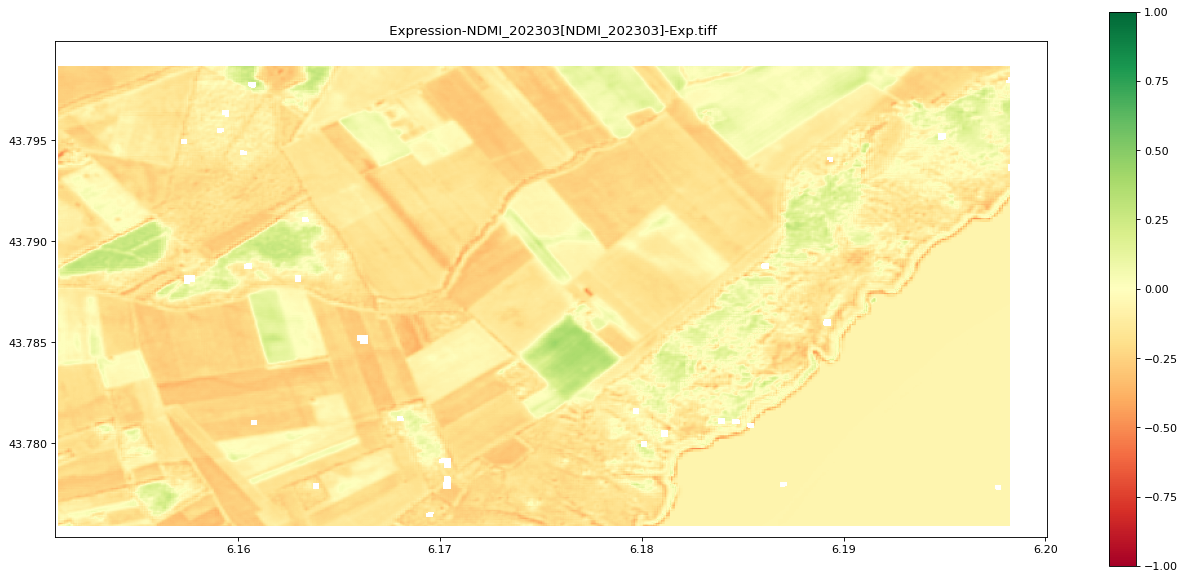

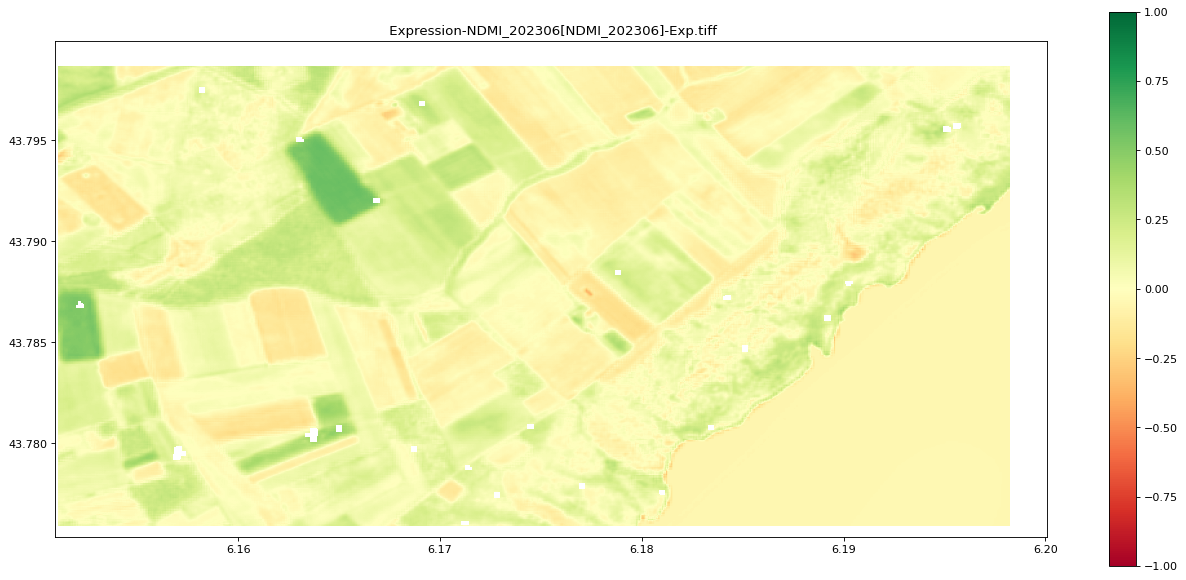

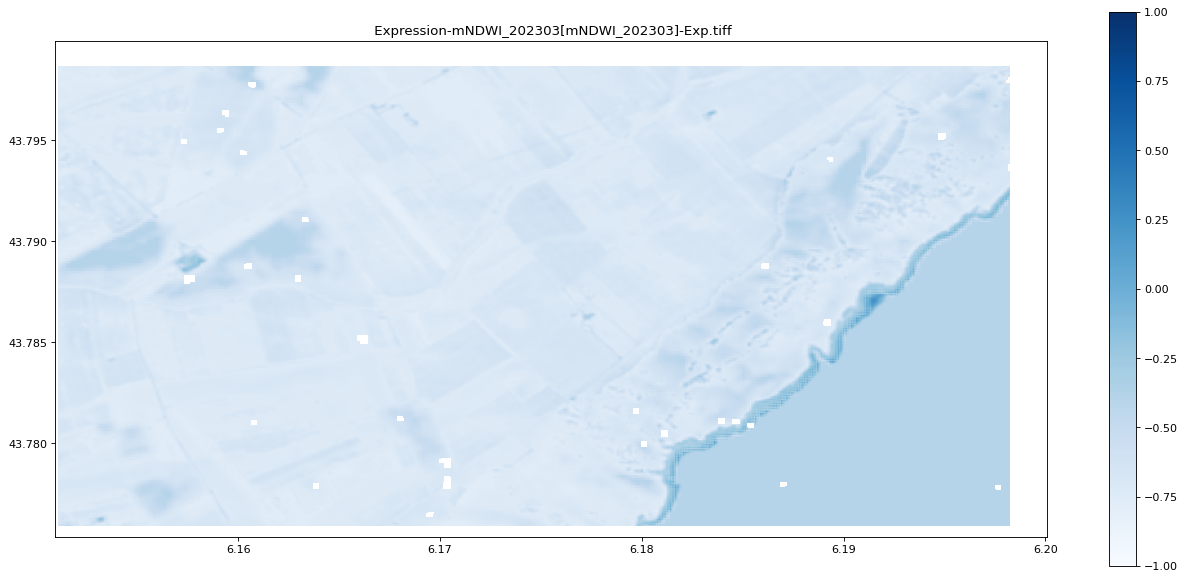

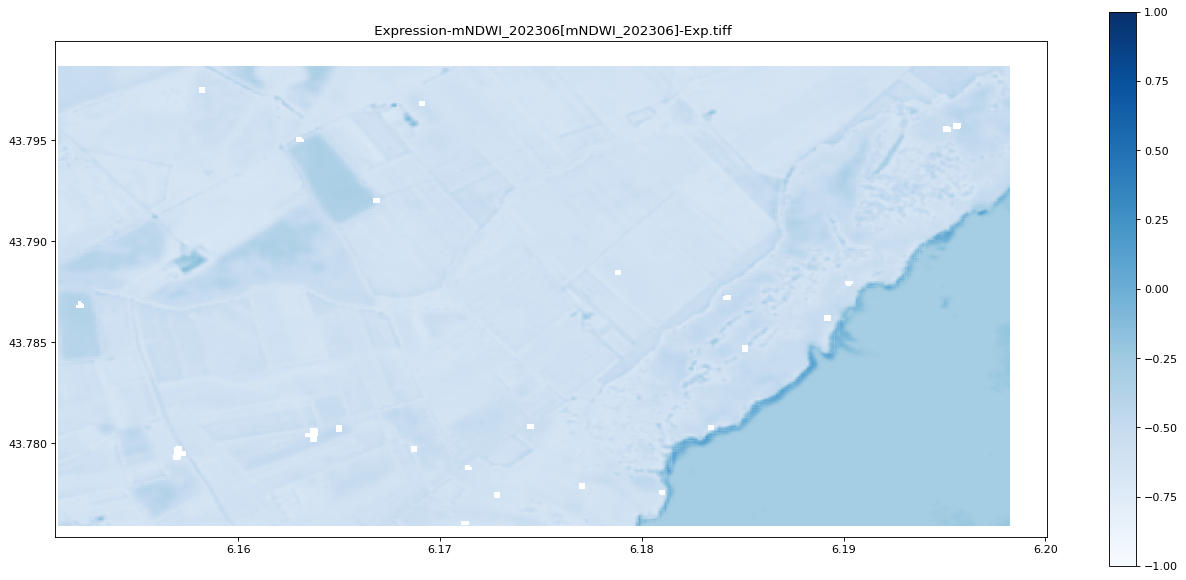

In [7]:
result_rasterfiles_list = NDWI_query.list_files()
result_rasterfiles_list.sort()
display_rasters_from_download(result_rasterfiles_list)

## Understanding the sample:

<b>Code:</b>

We are querying each of the data layers 49686,49361 and 49681 twice for two different temporal timestamps,one in March and the other in June, and identifying it by an `alias` like SWIR_1_202303, SWIR_1_202306 and so on.

Aliases specify a temporary name given to the particular layer's data that can be used later using the UDF expression. 

Subsequently we are defining other aliases named `mNDWI_202303`,`mNDWI_202306`, `NDMI_202303` and `NDMI_202306` which are UDF expressions that use the previously defined aliases,each of which we'll get to see outputs for.

We then specify the coordinates that covers a square area of farmland fields beside the Lake of Sainte-Croix, in order to demonstrate the increase in NDMI and mNDWI indices through the season of Spring.

Submitting the query using `query.submit_check_status_and_download()` runs the query asynchronously,checks it's status as it runs and, once complete, downloads the results of the query as a zip file named after the query Id.

<b>Output:</b>

The raster tiff files provide a visual representation of a particular index during a specific month, inferred by its file name.
Their respective .json files give you a brief summary/statistical analysis of the corresponding tiff file generated.

The `data_acknowledgement.txt` file contains acknowledgements associated with the data we provide. 

The `output.info` file maps the images files back to the Geospatial APIs data layers that were used to produce them.

<b>Output Analysis:</b>
- Both NDMI and mNDWI values typically range from -1 to 1. Negative NDMI values indicate areas with lower vegetation moisture content, potentially indicating drought stress or less water availability whereas positive values indicate areas with higher vegetation moisture content, indicative of healthy, well-watered vegetation. Negative mNDWI values indicate areas with low water content, such as built-up areas or dry soils whereas positive values indicate areas with high water content, such as vegetation or water bodies.
- The colormap of 'RdYlGn' used for displaying the NDMI tiffs easily helps us identify a substantial increase in vegetation cover of the farm land as the timeframe corresponds to the season of Spring when vegetation reaches peak moisture levels as plants actively photosynthesize and grow.
- Increase in NDMI is accompanied by an increase in mNDWI as well, as seen from the tiffs suggesting an increase in the water content in the lake(seen at the bottom corner portion of the tiff) due to spring runoff/water replenshishment from rainfall. We also see an increase in this index in places of thriving biomass due to irrigation or higher water retention in the vegetation.

Finally, let's observe the amount of NDMI increase in vegetation in the farmland during Spring by displaying the calculated difference in pixel values between the two raster files of March and June.

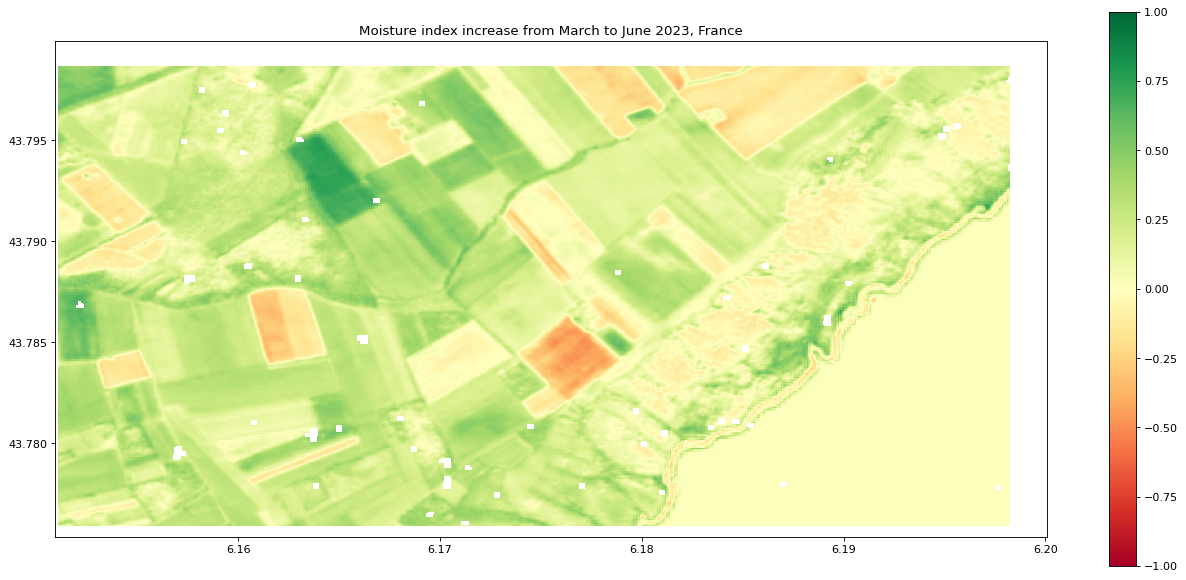

In [8]:
for file in result_rasterfiles_list :
       if (("NDMI_202303") in file)&(file.endswith("tiff")):
          arrayNDMI_Mar=np.array(PIL.Image.open(file))
          mask = (arrayNDMI_Mar == -9999)
          masked_array_Mar = np.ma.masked_array(arrayNDMI_Mar, mask)  #masking the no data points
          arrayNDMI_extent = get_extent(file+'.json')
       elif (("NDMI_202306") in file)&(file.endswith("tiff")):
          arrayNDMI_Jun=np.array(PIL.Image.open(file))                
          mask = (arrayNDMI_Jun == -9999)
          masked_array_June = np.ma.masked_array(arrayNDMI_Jun, mask) #masking the no data points
plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
plt.imshow(masked_array_June-masked_array_Mar,cmap = 'RdYlGn', vmin=-1, vmax=1,extent=arrayNDMI_extent)
plt.colorbar() # Adds the color bar
plt.title("Moisture index increase from March to June 2023, France")
plt.show( ) # Displays the image
    

## NDMI and mNDWI applications:
- Apart from monitoring vegetation moisture content to assess plant health and water stress levels to predict possible drought conditions, farmers can use NDMI to make informed decisions on irrigation timing and identify areas needing supplemental watering.
- By monitoring changes in water content, mNDWI can be used to identify seasonal variations in lake and river levels, and assess wetland dynamics.It also helps identify flood-prone areas, plan infrastructure developments, and assess the ecological impacts of urbanization on water resources.